In [ ]:
# Reseteamos todas las variables del entorno
%reset
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


# **CONFIGURACION DEL ENTORNO**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

sys.path

['/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code//SpeechEmotionRecognition',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'
EMODB_PATH = GPATH + 'data/EMODB/'

# Espectogramas
SPECT_IMG = GPATH + 'data/spectrograms/'
SPECTOGRAM_MODEL = SPECT_IMG + 'mfcc_savee_tess/test_german'

# Maps
EMOTION_MAP = {4:'neutral', 2:'happy', 3:'sad', 0:'angry', 1:'disgust'}
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']

## **1. DATOS**

In [ ]:
# Leemos EMO-DB
EMOTION_EMODB_MAP = {'F':'happy', 'T':'sad', 'W':'angry','E':'disgust', 'N':'neutral'}
emotion=[]
path = []

for filename in os.listdir(EMODB_PATH):
  str_path = EMODB_PATH +  '/' + str(filename)
  emo_capital = filename[5]
  if emo_capital in EMOTION_EMODB_MAP:
    emotion.append(EMOTION_EMODB_MAP[emo_capital])
    path.append(str_path)
  
EMODDB_df = pd.DataFrame(columns=['emotion', 'path'])
EMODDB_df['emotion'] = emotion
EMODDB_df['path'] = path

class_distribution = EMODDB_df['emotion'].value_counts()
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [ ]:
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [ ]:
# from src.SpeechDataProcess import SpeechDataProcess
# data = SpeechDataProcess('TESS', TESS_PATH)
# TESS_df = data.read()
# data = SpeechDataProcess('SAVEE', SAVEE_PATH)
# SAVEE_df = data.read()

In [ ]:
emotion=[]
path = []
reduced_values = ['a', 'd', 'h', 'sa', 'n']

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    label = filename[0]
    if filename[1].isalpha() : label = filename[0] + filename[1] 
    # Solo los valores reducidos
    if label in reduced_values:
      path.append(str_path)
      if(label=='a'):
          emotion.append("angry")
      elif(label=='h'):
          emotion.append("happy")
      elif(label=='f'):
          emotion.append("fear")
      elif(label=='d'):
          emotion.append("disgust")
      elif(label=='n'):
          emotion.append('neutral')
      elif(label=='sa'):
          emotion.append("sad")
      elif(label=='su'):
          emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral    120
disgust     60
angry       60
sad         60
happy       60
Name: emotion, dtype: int64


In [ ]:
# Leemos TESS

emotion=[]
path = []
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']
for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)

    # Solo los valores reducidos
    if label.lower() in reduced_values:
      path.append(str_path)
      emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
print( TESS_df['emotion'].value_counts() )
# TESS_df.sample(5)

Size of the dataset: 2000 

neutral    400
angry      400
disgust    400
sad        400
happy      400
Name: emotion, dtype: int64


In [ ]:
if len(TESS_df.emotion.unique()) == len(SAVEE_df.emotion.unique()) and len(TESS_df.emotion.unique()) == len(EMODDB_df.emotion.unique()):
  print("Todas las dimensiones son correctas")

Todas las dimensiones son correctas


### **1.2 EXTRACCION DE ESPECTROGRAMAS**

In [ ]:
# from src.MFCC import MFCC

In [33]:
from PIL import Image
import cv2

class MFCC():
    '''
    Esta clase gestiona la generacion de las caracteristicas MFCC a traves de un dataframe en
    cuya estructura se asumen las columnas path y emotion.

    Notas
    -------
    La direccion de salida que se especifica, se refiere a donde se guardaran los
    archivos serializables, no a la generacion de datos (imagenes), que se debera
    de pasar en la funcion correspondiente
    '''

    def __init__(self, df_data, dataset_name, outpath='', n_features=40):

        self.df_data = df_data
        self.n_features = n_features
        self.outpath = outpath
        self.dataset_name = str(dataset_name)

    def get_features(self, modifier):
        '''
        Extrae las caracteristicas de un conjunto de pistas de audio a
        partir de un dataframe usando librosa

        Aguments
        ---------
          df : dataframe
            Dataframe que contiene el path donde se encuentra la pista de audio
          modifier: Function
            Funcion que modifica los datos

        Return
        -------
        data: np.array
          Caracteristicas extraidas

        '''
        bar_data_range = tqdm(range(len(self.df_data)))
        data = pd.DataFrame(columns=['data'])
        for index in bar_data_range:
            data_features = modifier(self.df_data.path[index])
            data.loc[index] = [data_features]

        return data

    def get_features_single_file(self, pathfile):
        '''
        Extrae las caracteristicas  de una unica pista de audio usando MFCC.py
        a traves de librosa.

        Aguments
        ---------
          pathfile: str
            Path del archivo del que se extraeran las caracteristicas

        Return
        -------
          data_features

        '''
        X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        data_features = np.mean(mfcc.T, axis=0)

        return data_features

    def get_features_white_noise(self, pathfile):
        '''
        Extrae las caracteristicas  de una unica pista de audio usando MFCC.py
        a traves de librosa habiendoles aplicado ruido blanco.

        Aguments
        ---------
          pathfile: str
            Path del archivo del que se extraeran las caracteristicas

        Return
        -------
          data_features

        '''
        X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
        # X = librosa.core.load(random_sample)[0]

        x_data_wn = self.white_noise(X)
        mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
        data_features = np.mean(mfcc.T, axis=0)

        return data_features

    def white_noise(self, data):
        '''
        Agrega ruido blanco a una pista de audio
        '''
        wn_spectrum = np.random.randn(len(data))
        data_wn = data + 0.005 * wn_spectrum
        return data_wn

    def get_features_shiftted(self, pathfile):
        '''
        Extrae las caracteristicas  de una unica pista de audio usando MFCC.py
        a traves de librosa habiendo desplazado las frecuencias perviamente.

        Aguments
        ---------
          pathfile: str
            Path del archivo del que se extraeran las caracteristicas

        Return
        -------
          data_features

        '''
        X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
        # X = librosa.core.load(random_sample)[0]

        x_data_sf = self.shift_audio_sample(X)
        mfcc = librosa.feature.mfcc(y=x_data_sf, sr=sample_rate, n_mfcc=40)
        data_features = np.mean(mfcc.T, axis=0)

        return data_features

    def shift_audio_sample(self, data, f_low=-5, f_high=5, spec=1):
        '''
        Desplaza una señal acustica en un rango de frecuencia
        '''
        d_range = int(np.random.uniform(low=f_low, high=f_high) * spec)
        data_shiftted = np.roll(data, d_range)

        return data_shiftted

    def get_features_pitch(self, pathfile):
        '''
        Aplica modulacion del tono en cada muestra y despues extrae las caracteristicas
        usando el algoritmo MFCC.py

        Aguments
        ---------
          pathfile: str
            Path del archivo del que se extraeran las caracteristicas

        Return
        -------
          data_features

        '''
        X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
        # X = librosa.core.load(random_sample)[0]

        x_data_pt = self.pitch_shift(X)
        mfcc = librosa.feature.mfcc(y=x_data_pt, sr=sample_rate, n_mfcc=40)
        data_features = np.mean(mfcc.T, axis=0)

        return data_features

    def pitch_shift(self, data, sr, bins_per_octave=12, pitch_pm=2):
        '''
        Modula el tono y modifica la velocidad de una pista de audio
        '''
        pitch_change = pitch_pm * 2 * (np.random.uniform())
        data_pitch = librosa.effects.pitch_shift(data.astype('float64'), sr, n_steps=pitch_change,
                                                 bins_per_octave=bins_per_octave)
        return data_pitch

    def read_features_dataAugmentation(self, standard=True, data_augmentation=False):
        '''
        Devuelve y guarda en formato pkl de manera independiente las caracteristicas
        con tecnicas de aumento de datos
        '''
        features_wn = pd.DataFrame(columns=['data'])
        features_shiftted = pd.DataFrame(columns=['data'])
        features_pitch = pd.DataFrame(columns=['data'])

        # Leemos las caracteristicas estandar (sin data augmentation)
        if standard:
            features_standard = self.get_features(self.get_features_single_file)
            try:
                local_name = 'featuresMFCC_standard_' + self.dataset_name + '.pkl'
                pickle.dump(features_standard, open(self.outpath + local_name, 'wb'))
            except Exception as ex:
                print(ex)
            print("Caracteristicas estandar serializadas")

        if data_augmentation:
            # Leemos para Ruido Blanco
            features_wn = self.get_features(self.get_features_white_noise)
            try:
                local_name = 'featuresMFCC_wn_' + self.dataset_name + '.pkl'
                pickle.dump(features_wn, open(self.outpath + local_name, 'wb'))
            except Exception as ex:
                print(ex)
            print("Caracteristicas aumentadas con Ruido Blanco serializadas")

            # Leemos para Desplazamiento del Sonido
            features_shiftted = self.get_features(self.get_features_shiftted)
            try:
                local_name = 'featuresMFCC_shiftted_' + self.dataset_name + '.pkl'
                pickle.dump(features_shiftted, open(self.outpath + local_name, 'wb'))
            except Exception as ex:
                print(ex)
            print("Caracteristicas aumentadas con Desplazamiento serializadas")

            # Leemos para Modificacion del Tono
            features_pitch = self.get_features(self.get_features_pitch)
            try:
                local_name = 'featuresMFCC_pitch_' + self.dataset_name + '.pkl'
                pickle.dump(features_pitch, open(self.outpath + local_name, 'wb'))
            except Exception as ex:
                print(ex)
            print("Caracteristicas aumentadas con Modulacion serializadas")

        return features_standard, features_wn, features_shiftted, features_pitch

    def load_spectograms_dataset(self, path, dimensions, verbose=True):
        '''
        Devuelve un dataframe con las imágenes generadas que se usarán tanto en el entrenamiento
        como en test. Asume que en el path especificado existen esos archivos.

        Arguments:
        ----------
          path: str
            Directorio donde se encuentran las imagenes
          mfcc: boolean
            Especifica si se añaden los espectogramas MFCC al dataset
          mel: boolean
            Especifica si se añaden los espectogramas de MEL al dataset
          classes: dictionary
            Categorias a las que pertenecen las imagenes
          verbose: boolean
            Especifica si se activan los mensajes mientras se leen las imagenes

        Returns:
        ----------
        '''
        list_images = []
        labels = []

        mfcc_img, mfcc_lb = self.__load_images(path, dimensions, sorted(os.listdir(path)) )
        list_images.extend(mfcc_img)
        labels.extend(mfcc_lb)

        return list_images, labels

    def __load_images(self, path, dimensions, classes, verbose=True):

        '''
        Lee las imágenes que se cargarán desde un determinado directorio
        Arguments:
        ----------
          path: str
            Directorio donde se encuentran las imagenes
          classes: dictionary
            Categorias a las que pertenecen las imagenes
          verbose: boolean
            Especifica si se activan los mensajes mientras se leen las imagenes

        Returns:
        ----------
        '''
        list_images = []
        labels = []
        print(classes)
        for index, emotion in enumerate(classes):
            emodir = os.path.join(path, emotion)
            files = os.listdir(emodir)
            images = [file for file in files if file.endswith("jpg")]
            n = len(images) - 92
            images = images[n:]
            if verbose:
                print("Leídas {} espectogramas pertenecientes a {}".format(len(images), emotion))
            for image_name in images:
                image = cv2.imread(os.path.join(emodir, image_name))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                img_arr = Image.fromarray(image, 'RGB')
                resized_img = img_arr.resize((dimensions[0], dimensions[1]))

                list_images.append(np.array(resized_img))
                labels.append(index)

        return list_images, labels


    def generate_spectrograms(self, output_path):
        '''
        Genera y almacena espectogramas unas caracteristicas espeficicas.
        Si la ruta donde se guarda el archivo no existe, la crea.
        Aguments
        ---------
        df: DataFrame
          dataframe donde estan almacenados los datos

        output_path: str
          Ruta donde se almacenaran los archivos generados

        '''

        bar_data_range = tqdm(range(len(self.df_data)))
        data = pd.DataFrame(columns=['data'])

        for index in bar_data_range:
          self.__save_spefrogram_shiffted(self.df_data.path[index], self.df_data.emotion[index], output_path, index)
          self.__save_mfccspectrograma(self.df_data.path[index], self.df_data.emotion[index], output_path, index)
            
              

    def __save_mfccspectrograma(self, pathfile, emotionName, output_path, index):
        '''
        Genera un espectograma como imagen a partir de un archivo, y lo guarda en una ruta especificada.
        Si la ruta donde se guarda el archivo no existe, la crea.
        Aguments
        ---------
        pathfile: str
          Ruta donde se encuentra el archivo.

        output_path: str
          Ruta donde se guardara la imagen generada.
        '''
        X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
        features_mfccspectrogram = librosa.feature.mfcc(X, sr=sample_rate, n_mfcc=20)
        fig = plt.figure(figsize=(12, 4))
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        librosa.display.specshow(features_mfccspectrogram, sr=sample_rate, x_axis='time', y_axis='mel')

        filename = output_path + emotionName + "/" + self.dataset_name + "_mfccspectrogram_" + str(index) + ".jpg"
        if not os.path.exists(output_path + emotionName):
            os.makedirs(output_path + emotionName)

        plt.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=-0.05)
        plt.close()
    

    def __save_spefrogram_shiffted(self, pathfile, emotionName, output_path, index):
      X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
      x_data_pt = self.pitch_shift(X, sample_rate)
      mfcc = librosa.feature.mfcc(y=x_data_pt, sr=sample_rate, n_mfcc=40)
      # data_features = np.mean(mfcc.T, axis=0)

      fig = plt.figure(figsize=(12, 4))
      ax = plt.Axes(fig, [0., 0., 1., 1.])
      ax.set_axis_off()
      fig.add_axes(ax)
      librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', y_axis='mel')

      filename = output_path + emotionName + "/" + self.dataset_name + "_mfccspectrogramShiftted_" + str(index) + ".jpg"
      if not os.path.exists(output_path + emotionName):
        os.makedirs(output_path + emotionName)

      plt.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=-0.05)
      plt.close()

In [34]:
# features_spectMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = "SAVEE")
# features_spectMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = "TESS")

features_spectMFCC_EMODB = MFCC(df_data = EMODDB_df, dataset_name = "EMODB")
# list_images, labels = featuresMFCC_SAVEE.load_images(IMG_MFCC, (40,40))

In [35]:
# # Genero los espectrogramas
# features_spectMFCC_SAVEE.generate_spectrograms(SPECT_IMG)
# features_spectMFCC_TESS.generate_spectrograms(SPECT_IMG)

# Genero los espectogramas de test
features_spectMFCC_EMODB.generate_spectrograms(SPECT_IMG + 'test_emodb/')



100%|██████████| 385/385 [05:21<00:00,  1.20it/s]


In [ ]:
list_images_savee_tess, labels = features_spectMFCC_TESS.load_spectograms_dataset(SPECTOGRAM_MODEL, (30,40))

['angry', 'disgust', 'happy', 'neutral', 'sad']
Leídas 460 espectogramas pertenecientes a angry
Leídas 460 espectogramas pertenecientes a disgust
Leídas 460 espectogramas pertenecientes a happy
Leídas 524 espectogramas pertenecientes a neutral
Leídas 460 espectogramas pertenecientes a sad


In [ ]:
array_images_savee_tess = np.array(list_images_savee_tess)
print("{} imagenes con dimension {}".format(array_images_savee_tess.shape[0], array_images_savee_tess.shape[1:]))

2364 imagenes con dimension (40, 30, 3)


In [36]:
list_images_emodb, labels_emodb = features_spectMFCC_EMODB.load_spectograms_dataset(SPECT_IMG + 'test_emodb/', (30,40))
array_images_emodb= np.array(list_images_emodb)

['angry', 'disgust', 'happy', 'neutral', 'sad']
Leídas 92 espectogramas pertenecientes a angry
Leídas 92 espectogramas pertenecientes a disgust
Leídas 92 espectogramas pertenecientes a happy
Leídas 92 espectogramas pertenecientes a neutral
Leídas 92 espectogramas pertenecientes a sad


## **2. DEFINICION DEL MODELO**

In [37]:
def get_model_LSTM_CNN(shape, classes):
  model = Sequential()

  # 1 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = shape, activation = 'relu')) # (128, 128, 3)
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 2 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 3 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # Capa Flatten
  model.add(Flatten())
  model.add(Dropout(rate = 0.5))

  # Capas LSTM 1D
  model.add(Reshape((1, 960))) 
  model.add(LSTM(units = 50, return_sequences = True, dropout = 0.5))
  model.add(LSTM(units = 20, return_sequences = False, dropout = 0.5))

  model.add(Dense(classes, activation = 'softmax'))

  return model


def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')


def processData(data, labels, test_size = 0.25):
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)

  # one hot encoding 
  lb = LabelEncoder()
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))

  # Normalization as per the standard NN process
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)

  X_train = (X_train - mean)/std
  X_test = (X_test - mean)/std

  return X_train, X_test, y_train, y_test

  

#### **2.1 ENTRENAMIENTO**

In [39]:
X_train, X_test, y_train, y_test = processData(array_images_savee_tess, labels, 0.3)

In [40]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_train.shape, y_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_test.shape, y_test.shape))

Entrenamiento: Datos con dimension (1654, 40, 30, 3), y clases con (1654, 5)
Test: Datos con dimension (710, 40, 30, 3), y clases con (710, 5)


In [41]:
model = get_model_LSTM_CNN(X_train.shape[1:], y_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 7, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                      batch_size=32, 
                      epochs=100, 
                      validation_data=(X_test, y_test))

Epoch 1/100
52/52 [==============================] - 31s 147ms/step - loss: 1.5954 - accuracy: 0.2313 - val_loss: 1.5294 - val_accuracy: 0.3423
Epoch 2/100
52/52 [==============================] - 6s 120ms/step - loss: 1.5280 - accuracy: 0.3258 - val_loss: 1.4322 - val_accuracy: 0.4521
Epoch 3/100
52/52 [==============================] - 6s 120ms/step - loss: 1.4706 - accuracy: 0.3668 - val_loss: 1.3024 - val_accuracy: 0.4704
Epoch 4/100
52/52 [==============================] - 6s 120ms/step - loss: 1.3370 - accuracy: 0.4557 - val_loss: 1.0728 - val_accuracy: 0.6423
Epoch 5/100
52/52 [==============================] - 6s 120ms/step - loss: 1.1145 - accuracy: 0.6022 - val_loss: 0.6823 - val_accuracy: 0.8239
Epoch 6/100
52/52 [==============================] - 6s 120ms/step - loss: 0.8596 - accuracy: 0.7226 - val_loss: 0.5100 - val_accuracy: 0.8521
Epoch 7/100
52/52 [==============================] - 6s 120ms/step - loss: 0.6577 - accuracy: 0.7857 - val_loss: 0.4568 - val_accuracy: 0.860

45/45 [==============================] - 1s 15ms/step - loss: 0.2892 - accuracy: 0.9141
Loss: 0.28918296098709106 
Accuracy: 91.40844941139221%


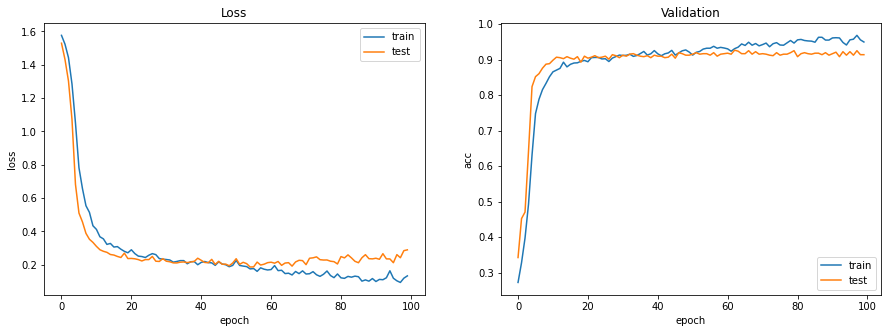

In [43]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test, y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **2.2 EVALUACION**

In [48]:
X_emo_train, X_emo_test, y_emo_train, y_emo_test = processData(array_images_emodb, labels_emodb, 0.01)

In [49]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_emo_train.shape, y_emo_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_emo_test.shape, y_emo_test.shape))

Entrenamiento: Datos con dimension (455, 40, 30, 3), y clases con (455, 5)
Test: Datos con dimension (5, 40, 30, 3), y clases con (5, 4)


In [50]:
from sklearn.metrics import classification_report

predicted_y = model.predict(X_emo_train)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(y_emo_train, axis=1)


# Mapeo el nombre de las clases
predicted_y = list(map(EMOTION_MAP.get, predicted_y))
categorical_labels = list(map(EMOTION_MAP.get, categorical_labels))

In [51]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.30      0.23      0.26        91
     disgust       0.17      0.20      0.19        90
       happy       0.49      0.20      0.28        91
     neutral       0.31      0.59      0.40        91
         sad       0.27      0.20      0.23        92

    accuracy                           0.28       455
   macro avg       0.31      0.28      0.27       455
weighted avg       0.31      0.28      0.27       455

